In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

In [47]:
class TorchCNN(nn.Module):
    def __init__(self):
        """
        Initialize a 3-layer CNN.

        Args:
            in_channels: number of features of the input image
            hidden_channels: list of two numbers which are number of hidden features
            out_features: number of features in output layer
        """
        super(TorchCNN, self).__init__()

        self.layers = []

        # input layer
        self.convi = nn.Conv2d(1, 96//4, kernel_size=7, stride=2, padding = 1)
        self.relui = nn.ReLU()

        self.layers = [self.convi, self.relui]
        # hidden layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(96)
        self.conv1 = nn.Conv2d(96//4, 256//4, kernel_size=5, stride=2, padding = 1)
        self.relu1 = nn.ReLU()

        self.layers = self.layers + [self.pool1, self.norm1, self.conv1, self.relu1]

        # hidden layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm2 = nn.LocalResponseNorm(256)
        self.conv2 = nn.Conv2d(256//4, 384//4, kernel_size=3, stride=1, padding = 1)
        self.relu2 = nn.ReLU()

        self.layers = self.layers + [self.pool2, self.norm2, self.conv2, self.relu2]

        # hidden layer 3
        self.conv3 = nn.Conv2d(384//4, 384//4, kernel_size=3, stride=1, padding = 1)
        self.relu3 = nn.ReLU()

        self.layers = self.layers + [self.conv3, self.relu3]

        # hidden layer 4
        self.conv4 = nn.Conv2d(384//4, 256//4, kernel_size=3, stride=1, padding = 1)
        self.relu4 = nn.ReLU()

        self.layers = self.layers + [self.conv4, self.relu4]

        # hidden layer 5
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.layers = self.layers + [self.pool5]

        # hidden layer 6
        self.flat1 = nn.Flatten()
        self.lino = nn.Linear(6*6*256//4, 10)
        self.softo = nn.Softmax(dim=1)

        self.layers = self.layers + [self.flat1, self.lino, self.softo]

#         # hidden layer 7
#         self.lin7 = nn.Linear(4096, 4096)

#         self.layers = self.layers + [self.lin7]
        
#         # output layer
#         self.lino = nn.Linear(4096, 10)
#         self.softo = nn.Softmax(dim=1)
        
#         self.layers = self.layers + [self.lino, self.softo]

    def forward(self, x):
        i=0
        for layer in self.layers:
            x = layer(x)
#             print(type(layer))
#             print(x.size())
#             if type(layer)==torch.nn.modules.conv.Conv2d:
#                 i+=1
#                 print(f'layer {i}, {type(layer)}')
        return x

In [6]:
mnist_train = torch.load('../data/MNIST/processed/training.pt')
mnist_test = torch.load('../data/MNIST/processed/test.pt')


In [ ]:
# fashiomnist_train = datasets.FashionMNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
# fashiomnist_test = datasets.FashionMNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

In [8]:
transform = transforms.Compose([transforms.Resize((224,224))])
train = []
for i in range(len(mnist_train[0])//100):
    train.append(transform(mnist_train[0][i*100:i*100+100]))
    
train = torch.stack(train).view(60000,224,224)

train_data = []
for data, label in zip(train, mnist_train[1]):
    train_data.append([data[None,:,:],label])
    
test = []
for i in range(len(mnist_test[0])//100):
    test.append(transform(mnist_test[0][i*100:i*100+100]))
    
test = torch.stack(test).view(10000,224,224)

test_data = []
for data, label in zip(test, mnist_test[1]):
    test_data.append([data[None,:,:],label])

In [9]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)

In [10]:
i1, l1 = next(iter(test_loader))

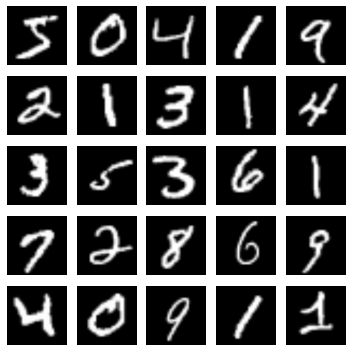

In [19]:
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i in range(25):
    x, y = train_data[i]
    ax = axs[i // 5][i % 5]
    ax.imshow(x.view(224, 224), cmap='gray')
    ax.axis('off')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

In [48]:
# Try using gpu instead of cpu
device = try_gpu()
# device = 'cpu'

net = TorchCNN()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [49]:
summary(net, (1,224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 110, 110]           1,200
              ReLU-2         [-1, 24, 110, 110]               0
         MaxPool2d-3           [-1, 24, 55, 55]               0
 LocalResponseNorm-4           [-1, 24, 55, 55]               0
            Conv2d-5           [-1, 64, 27, 27]          38,464
              ReLU-6           [-1, 64, 27, 27]               0
         MaxPool2d-7           [-1, 64, 13, 13]               0
 LocalResponseNorm-8           [-1, 64, 13, 13]               0
            Conv2d-9           [-1, 96, 13, 13]          55,392
             ReLU-10           [-1, 96, 13, 13]               0
           Conv2d-11           [-1, 96, 13, 13]          83,040
             ReLU-12           [-1, 96, 13, 13]               0
           Conv2d-13           [-1, 64, 13, 13]          55,360
             ReLU-14           [-1, 64,

In [43]:
def evaluate_accuracy(data_loader, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for i, (X, y) in enumerate(data_loader):
        if i%10==0:
            print(i)
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        X = X.float()
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

In [44]:
epochs = 5

# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []

for epoch in range(epochs):

    # Network in training mode and to device
    net.train()
#     net.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):
        
        if i%50==0:
            print(f'batch {i}')

        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.float()
#         y_batch = y_batch.type(torch.LongTensor) 
#         x_batch = x_batch.type(torch.LongTensor) 

        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = net(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)
        
        # Backward computation and update
        loss.backward()
        optimizer.step()

    # Compute train and test error
    train_acc = 100*evaluate_accuracy(train_loader, net.to('cpu'))
    test_acc = 100*evaluate_accuracy(test_loader, net.to('cpu'))
    
    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

batch 0
batch 50


KeyboardInterrupt: 

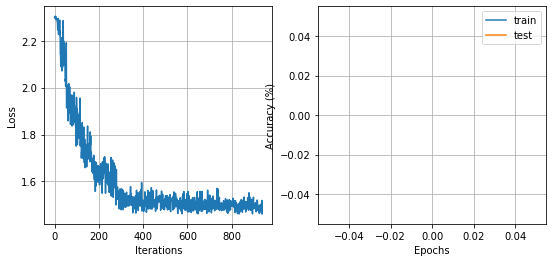

In [31]:
# Plot training curves
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.grid()

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label = 'train')
plt.plot(test_accs, label = 'test')
plt.legend()
plt.grid()

In [37]:
train_acc = 100*evaluate_accuracy(train_loader, net.to('cpu'))
test_acc = 100*evaluate_accuracy(test_loader, net.to('cpu'))

KeyboardInterrupt: 